# 🔍 Image Classification with Grad-CAM Visualization

**Fixing a Deprecation Issue in PyTorch Grad-CAM Library**:

In my env, the file path is: miniconda3/envs/my_env/lib/python3.12/site-packages/pytorch_grad_cam/utils/image.py

Problematic Lines:
```python
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plt.close(fig=fig)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
```

Replacement Code:
```python
buf = fig.canvas.buffer_rgba()
data = np.frombuffer(buf, dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
plt.close(fig=fig)
```

## 📦 Imports and Helpers

In [14]:
import os, json, torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import warnings
warnings.filterwarnings("ignore")

## 🧠 Model Loading and Utilities

In [15]:
# --- Safe label lookup ---
def get_label(model, idx):
    id2label = model.config.id2label
    key = str(idx) if str(idx) in id2label else idx
    return id2label[key]


# --- Universal model loader (handles base or LoRA) ---
def load_any_model(model_dir: str):
    cfg_path = os.path.join(model_dir, "config.json")
    if not os.path.exists(cfg_path):
        raise FileNotFoundError(f"Missing {cfg_path}")

    with open(cfg_path, "r") as f:
        cfg = json.load(f)
    class_names = cfg.get("classes", [])
    num_classes = len(class_names)

    base_model_dir = os.path.join(model_dir, "model")
    lora_base = os.path.join(model_dir, "base_model")
    lora_adapter = os.path.join(model_dir, "lora_adapter")

    # ✅ Full fine-tuned model
    if os.path.exists(base_model_dir):
        model = AutoModelForImageClassification.from_pretrained(base_model_dir)
        processor = AutoImageProcessor.from_pretrained(base_model_dir)
        return model, processor, class_names

    # ✅ LoRA adapter
    if os.path.exists(lora_base) and os.path.exists(lora_adapter):
        from peft import PeftModel, PeftConfig

        peft_cfg = PeftConfig.from_pretrained(lora_adapter)
        model = AutoModelForImageClassification.from_pretrained(
            peft_cfg.base_model_name_or_path,
            num_labels=num_classes,
            label2id={cls: i for i, cls in enumerate(class_names)},
            id2label={i: cls for i, cls in enumerate(class_names)},
            ignore_mismatched_sizes=True
        )
        model = PeftModel.from_pretrained(model, lora_adapter)
        processor = AutoImageProcessor.from_pretrained(peft_cfg.base_model_name_or_path)
        return model, processor, class_names

    raise ValueError(f"Unrecognized model format in {model_dir}")


# --- Wrapper for GradCAM ---
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).logits


## 🔥 Grad-CAM Generator

In [16]:
def gradcam_image(model, image, processor):
    inputs = processor(images=image, return_tensors="pt")
    img_tensor = inputs["pixel_values"].squeeze(0)

    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0)).logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    top_idx = int(np.argmax(probs))
    top_label = get_label(model, top_idx)
    top_prob = probs[top_idx]

    # Detect if model is LoRA
    from peft import PeftModel
    is_peft = isinstance(model, PeftModel)

    if is_peft:
        base = model.base_model.model
        target_layer = base.mobilevit.conv_1x1_exp
    else:
        target_layer = model.mobilevit.conv_1x1_exp

    model.train()
    img_tensor.requires_grad = True
    targets = [ClassifierOutputTarget(top_idx)]

    try:
        with GradCAM(
            model=HuggingfaceToTensorModelWrapper(model),
            target_layers=[target_layer]
        ) as cam:
            grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=targets)[0, :]
    finally:
        model.eval()

    rgb_img = np.float32(image.resize((256, 256))) / 255.0
    grad_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return grad_img, probs, top_label, top_prob


## 🔧 Prediction Function

In [17]:
def run_prediction(model_dir, image_path):
    # --- Load model ---
    model, processor, class_names = load_any_model(model_dir)
    model.eval()

    # --- Load image ---
    image = Image.open(image_path).convert("RGB")

    # --- Run GradCAM ---
    grad_img, probs, label, prob = gradcam_image(model, image, processor)

    # --- Plot side by side ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(grad_img)
    ax[1].set_title(f"Grad-CAM: {label} ({prob*100:.2f}%)", fontsize=11)
    ax[1].axis("off")

    # Horizontal legend
    legend_text = " | ".join([f"{cls}: {p*100:.2f}%" for cls, p in zip(class_names, probs)])
    plt.figtext(0.5, 0.02, legend_text, ha="center", fontsize=9)

    plt.tight_layout(rect=[0, 0.07, 1, 1])
    plt.show()

## 🚀 Run Prediction + Visualization

**📝 Example Usage**

Here's a step-by-step example to run predictions and visualize Grad-CAM for both LoRA and full fine-tuned models. Adjust the paths as needed for your specific models and images.

1. **Define the model directories and image path:**
   ```python
   model_dir_lora = "outputs/mobilevit-small_lora_20251001_144739"  # LoRA model
   model_dir_full = "outputs/cvt13_lora_vs_full_20251001_174401"  # Full fine-tuned model (adjust if needed)
   image_path = "Data/brain_tumor/train/glioma/brisc2025_test_00001_gl_ax_t1.jpg"

2. **Run prediction for the LoRA model:**
    ```python
    run_prediction(model_dir_lora, image_path)

3. **Run prediction for the full fine-tuned model:**
    ```python
    run_prediction(model_dir_full, image_path)

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([4, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


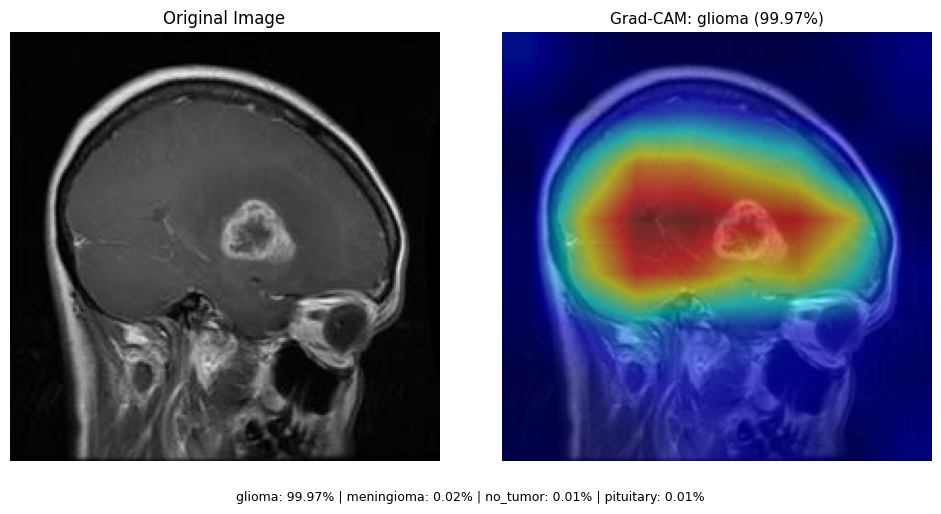

In [18]:
# Brain Tumor Example
model_dir_lora = "outputs/mobilevit-small_lora_20251001_210358"
image_path = "Data/brain_tumor/test/glioma/brisc2025_test_00221_gl_sa_t1.jpg"

run_prediction(model_dir_lora, image_path)

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([4, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


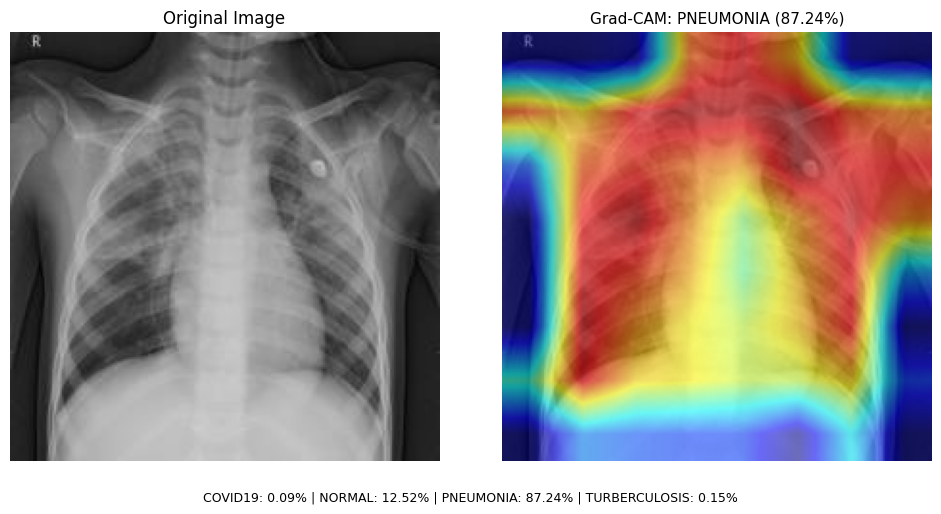

In [19]:
# Brain Tumor Example
model_dir_lora = "outputs/mobilevit-small_lora_20251001_210442"
image_path = "Data/chest-xray/test/PNEUMONIA/person3_virus_17.jpg"

run_prediction(model_dir_lora, image_path)

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([3, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


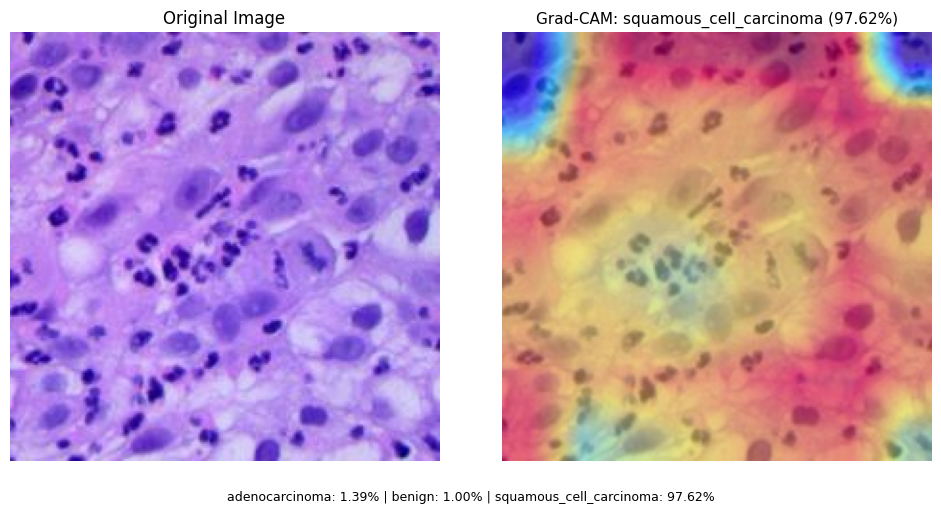

In [20]:
# Brain Tumor Example
model_dir_lora = "outputs/mobilevit-small_lora_20251001_210549"
image_path = "Data/lung-cancer/test/squamous_cell_carcinoma/0005.jpg"

run_prediction(model_dir_lora, image_path)